In [79]:
from pathlib import Path

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pdr
from marslab.bandset.mastcamz import ZcamBandSet, ls_zcam
from marslab.imgops.masking import skymask, threshold_mask

from roi_classifier import (SHARED_BAND_INDEX, add_rois, apply_homography,
                            apply_kmeans_to_masked, average_spectra,
                            compress_cube, filter_connected_components,
                            mask_cube, plot_spectra, trim_margins, uncompress)

In [80]:
CAMERA_FILTERS = {
    'L': [
        'L0R',
        'L0G',
        'L0B',
        'L1',
        'L2',
        'L3',
        'L4',
        'L5',
        'L6'
    ],
    'R': [
        'R0R',
        'R0G',
        'R0B',
        'R1',
        'R2',
        'R3',
        'R4',
        'R5',
        'R6'
    ]
}

# load, debayer data
SEARCH_PATH = Path("data/03484")
bs = ZcamBandSet(ls_zcam(SEARCH_PATH))
bs.load("all")
bs.bulk_debayer("all")

# load left and right data cubes
l_cube = np.array([bs.get_band(band) for band in CAMERA_FILTERS['L']])
r_cube = np.array([bs.get_band(band) for band in CAMERA_FILTERS['R']])

In [81]:
l_cube.shape

(9, 1200, 1648)

In [82]:
r_cube.shape

(9, 1200, 1648)

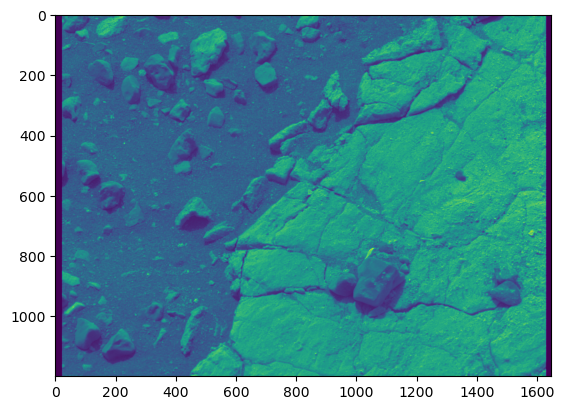

In [83]:
plt.imshow(l_cube[0])

In [84]:
# trim margins off of raw cubes
r_cube_trimmed = trim_margins(r_cube)
l_cube_trimmed = trim_margins(l_cube)

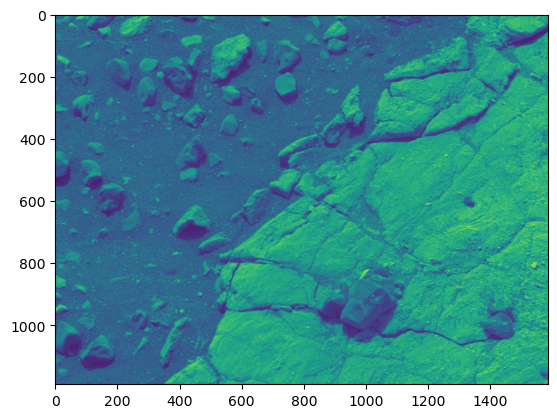

In [85]:
plt.imshow(r_cube_trimmed[0])

In [86]:
l_cube_mapped = apply_homography(l_cube_trimmed, r_cube_trimmed)

In [87]:
l_cube_mapped.shape

(9, 1190, 1585)

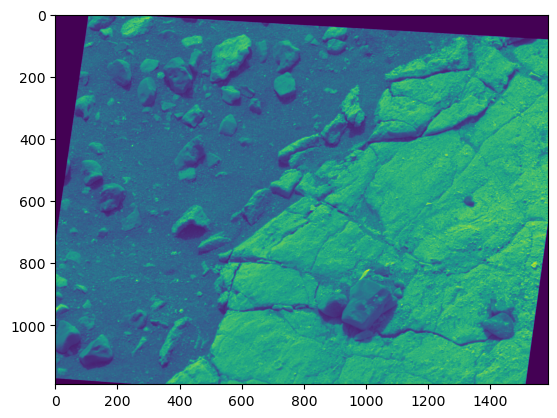

In [88]:
plt.imshow(l_cube_mapped[0])

In [89]:
full_cube = []

# average left/right views of Bayer and 800nm bands
for band in range(SHARED_BAND_INDEX+1):
    img = (l_cube_mapped[band] + r_cube_trimmed[band]) / 2
    full_cube.append(img)

# add left bands
l_num_bands = l_cube_trimmed.shape[0]
for band in range(SHARED_BAND_INDEX+1, l_num_bands):
    full_cube.append(l_cube_mapped[band])

# add right bands
r_num_bands = r_cube_trimmed.shape[0]
for band in range(SHARED_BAND_INDEX+1, r_num_bands):
    full_cube.append(r_cube_trimmed[band])

full_cube = np.array(full_cube)

In [90]:
full_cube.shape

(14, 1190, 1585)

In [91]:
# mask shaddows
shaddow_tmask = threshold_mask(r_cube_trimmed, (6, 99), operator='and')

# mask the sky
skymask_kwargs = {
    'percentile': 75,
    'edge_params': {"maximum": 5, "erosion": 3},
    'input_median': 5,
    'trace_maximum': 5,
    'cutoffs': {
        "extent": 0.05, "coverage": None, "v": 0.9, "h": None
        },
    'input_mask_dilation': None,
    'input_stretch': (10, 1),
    'floodfill': True,
    'trim_params': {"trim": False},
    'clear': True,
    'colorblock': False,
    'respect_mask': False,
}
sky_tmask = skymask(r_cube_trimmed, **skymask_kwargs)

# mask the overlap bewteen the cameras
overlap_mask = (l_cube_mapped[SHARED_BAND_INDEX] == 0)

# combine the masks into one
feature_mask = np.logical_or(shaddow_tmask, sky_tmask)
full_tmask = np.logical_or(feature_mask, overlap_mask)

cube_preprocessed = mask_cube(full_cube, full_tmask)

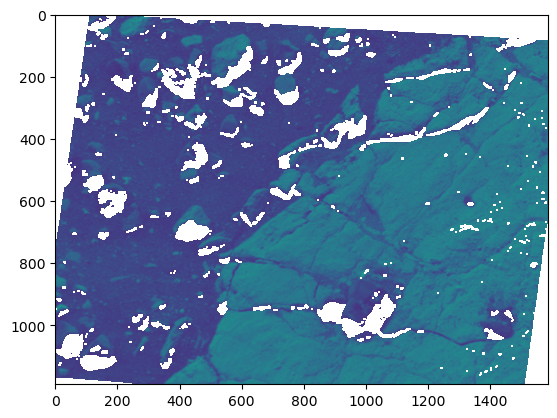

In [92]:
plt.imshow(cube_preprocessed[12])

In [93]:
compressed, pixel_locations = compress_cube(cube_preprocessed)

In [94]:
compressed.dtype

dtype('float64')

In [95]:
compressed.shape

(14, 1695001)

In [96]:
cube_preprocessed.shape[1:]

(1190, 1585)

In [97]:
pixel_locations.shape

(1695001, 2)

In [98]:
rebuilt = uncompress(compressed, pixel_locations, cube_preprocessed.shape)

In [99]:
rebuilt.shape

(14, 1190, 1585)

In [100]:
clustered = apply_kmeans_to_masked(cube_preprocessed, k=3)

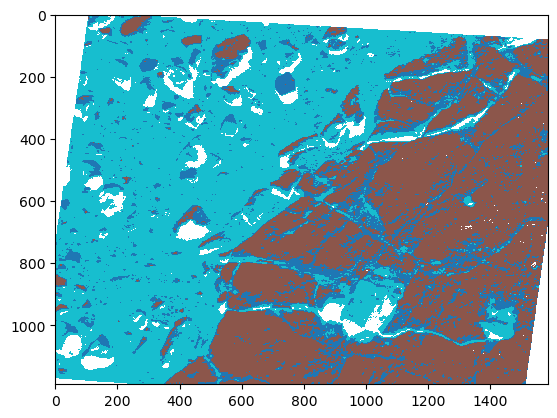

In [101]:
plt.imshow(clustered, cmap='tab10', interpolation='nearest')

In [102]:
float_rock_mask = filter_connected_components(clustered, 800, 20000)

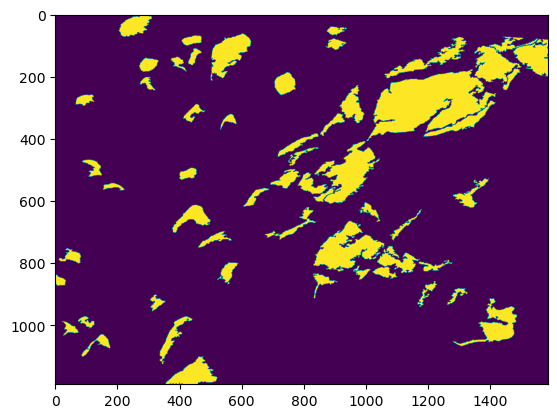

In [103]:
plt.imshow(float_rock_mask)

In [104]:
# compute cube prioritizing large surfaces
l_surfs_mask = np.logical_or(float_rock_mask, full_tmask)
l_surfs = mask_cube(cube_preprocessed, l_surfs_mask)

# compute cube prioritizing small surfaces
s_surfs_mask = np.logical_or(~float_rock_mask, full_tmask)
s_surfs = mask_cube(cube_preprocessed, s_surfs_mask)

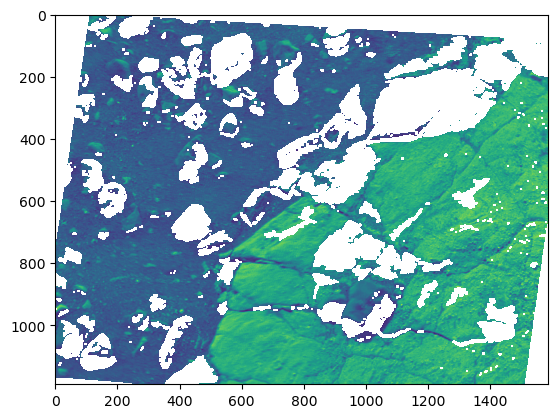

In [105]:
plt.imshow(l_surfs[0])

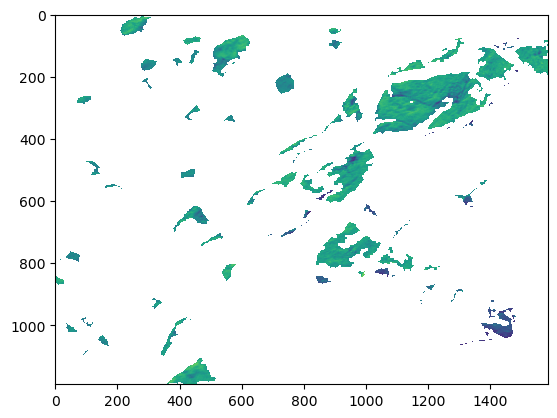

In [106]:
plt.imshow(s_surfs[0])

In [107]:
l_clustered = apply_kmeans_to_masked(l_surfs, k=4)
s_clustered = apply_kmeans_to_masked(s_surfs, k=4)

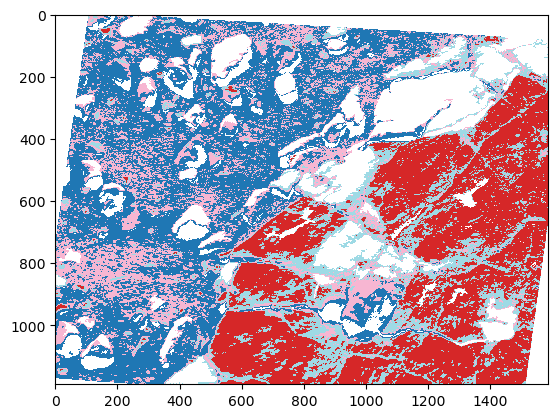

In [108]:
plt.imshow(l_clustered, cmap='tab20', interpolation='nearest')

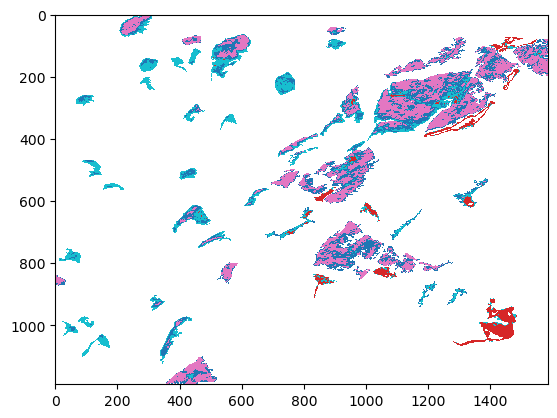

In [109]:
plt.imshow(s_clustered, cmap='tab10', interpolation='nearest')

In [110]:
s_rois = add_rois(s_clustered, min_region_sz=1200, max_region_sz=5000, center_thresh_dif=0, density_threshold=0.7)
l_rois = add_rois(l_clustered, min_region_sz=500, max_region_sz=5000, center_thresh_dif=50, density_threshold=0.5)


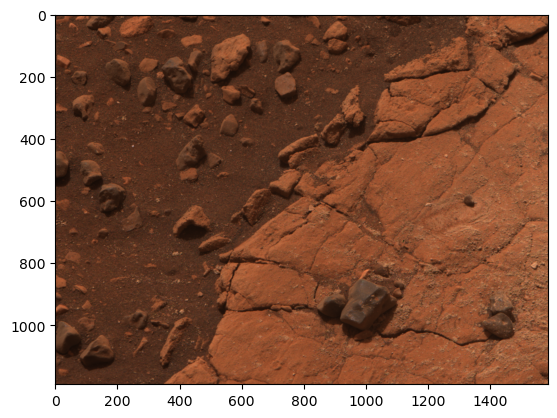

In [111]:
# creates rgb image from right bayer bands
red = r_cube_trimmed[0]
green = r_cube_trimmed[1]
blue = r_cube_trimmed[2]

rgb = np.stack([red, green, blue], axis=-1)
rgb_normalized = np.array(rgb / rgb.max())

plt.imshow(rgb_normalized)

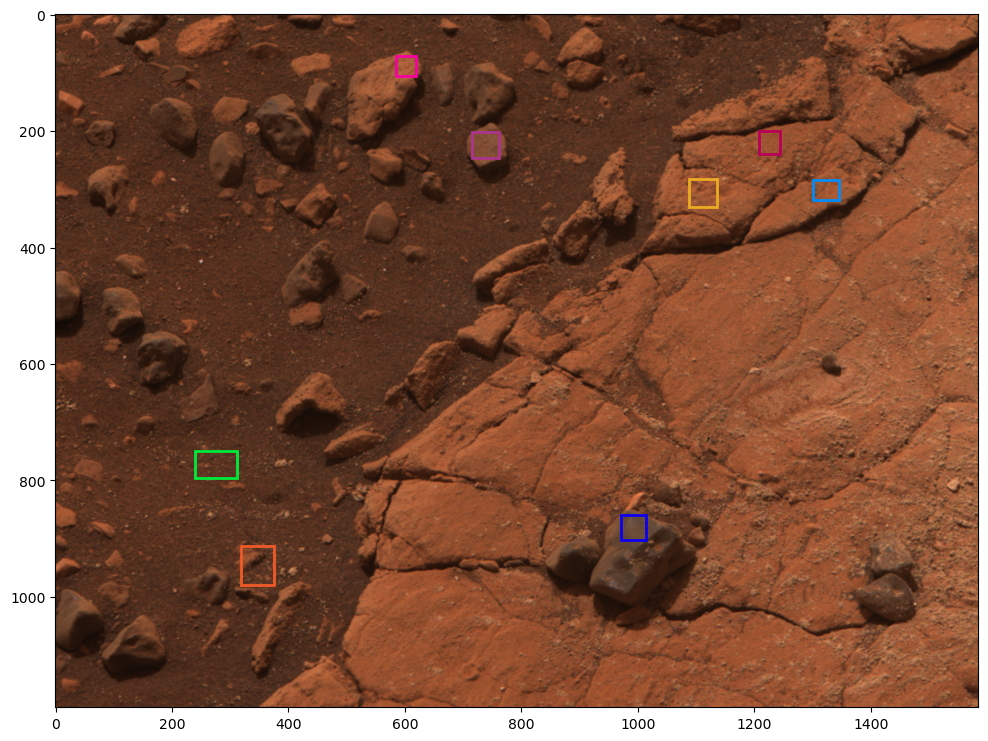

In [112]:
rois = s_rois + l_rois

fig, ax = plt.subplots(figsize=(12, 9))
im = ax.imshow(rgb_normalized)

# colors = [
#         "#F2AE2E",
#         "#F26E50",
#         "#D92A1A",
#         "#61BC2B",
#         "#2811C0",
#         "#15E4B1",
#         "#D16174",
#         "#136B8C",
#         "#DD6E12",
#         "#834C71"
#     ]

COLORS = [
        "#ebac23",
        "#b80058",
        "#008cf9",
        "#AB358A",
        "#F5029F",
        "#0E00EE",
        "#00EB39",
        "#f05a28"
    ]

color_i = 0
for x1, y1, x2, y2 in rois:
    if color_i == len(COLORS):
        color_i = 0
    
    curr_color = COLORS[color_i]
    
    roi = patches.Rectangle((x1, y1), x2, y2, edgecolor=curr_color, facecolor='none', linewidth=2)
    ax.add_patch(roi)
    
    color_i+=1

# convert rect coords to plot coords
for i in range(len(rois)):
    x1, y1, w, h = rois[i]
    x2 = x1 + w
    y2 = y1 + h
    rois[i] = (x1, y1, x2, y2)

plt.show()

In [113]:
path = bs.metadata["PATH"][6]  # R0
file = pdr.read(path)
solar_elevation = file.metaget('SOLAR_ELEVATION')

In [114]:
# taken from pplot_utils...
theta_rad = (
    (90 - solar_elevation['value']) * 2 * np.pi / 360
    if solar_elevation['value'] is not None
    else 2 * np.pi
)
# changed to not none
if solar_elevation['units'] is not None:
    photometric_scaling = np.cos(theta_rad)
else:
    photometric_scaling = 1

if solar_elevation['units'] is None and solar_elevation['value'] is None:
    y_axis_units = "IOF"
else:
    y_axis_units = "Relative Reflectance"

In [115]:
photometric_scaling

np.float64(0.8639348438184343)

In [116]:
photometrically_calibrated = cube_preprocessed / photometric_scaling

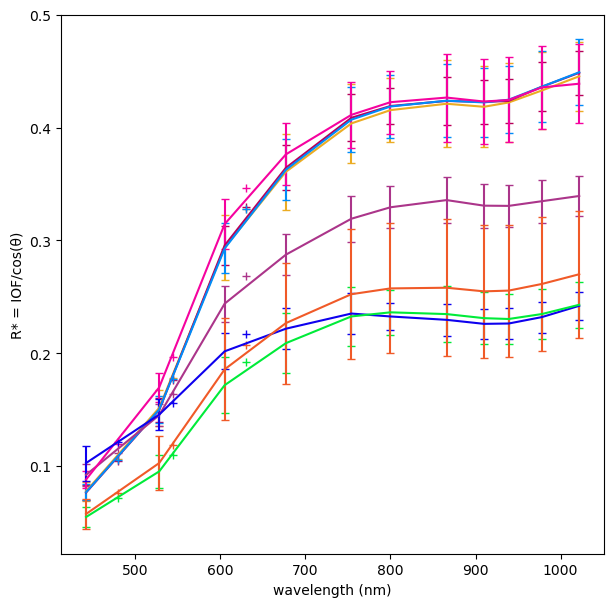

In [118]:
# calculate averaged spectra
spectra, stds = average_spectra(photometrically_calibrated, rois)
plot_spectra(spectra, stds, COLORS)